<img src="logo.png">  <br>
* ref : https://www.kaggle.com/c/bike-sharing-demand/overview/evaluation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')

# -------------------------------------------------
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import skew, kurtosis

sns.set()

In [2]:
train = pd.read_csv("./kaggle/bike_sharing_demand/train.csv")
test = pd.read_csv("./kaggle/bike_sharing_demand/test.csv")
sub = pd.read_csv("./kaggle/bike_sharing_demand/sampleSubmission.csv")


In [3]:
train.shape, test.shape

((10886, 12), (6493, 9))

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null   object 
 1   season      6493 non-null   int64  
 2   holiday     6493 non-null   int64  
 3   workingday  6493 non-null   int64  
 4   weather     6493 non-null   int64  
 5   temp        6493 non-null   float64
 6   atemp       6493 non-null   float64
 7   humidity    6493 non-null   int64  
 8   windspeed   6493 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB


In [6]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


## target 

#### casual + registered = count
* casual, registered 삭제
* target 불균형 확인

In [7]:
train_cp = train.copy()
print(train_cp.shape)
# casual + registered
train_cp['cr']=train_cp['casual'] + train_cp['registered']
# train_cp[['casual','registered','count','cr' ]].head(20) 
#cr count  : 일치하지않는 레코드
train_cp[train_cp['count'] != train_cp['cr']]['cr'].count()
del train_cp

(10886, 12)


In [8]:
train.drop(['casual', 'registered' ], axis=1, inplace=True)

## Object 타입 처리 

In [9]:
for df in [train, test]:
    df['datetime'] = pd.to_datetime(df['datetime'])
    # df['datetime'] = df['datetime'].astype('datetime64')

    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['hour'] = df['datetime'].dt.hour
    df['week'] = df['datetime'].dt.dayofweek  #월0  ~일6
    
    df.drop(['datetime'], axis=1, inplace=True)  #--- drop

## 1차점수 : 무조건 점수보다 보자(object x,  nan x)

#### 데이터 분리

#### 모델
* 랏쏘 : L1규제 -->  x|w|  중요하지 않은 피쳐의 회귀계수를 0으로 만들수 있다.
* 릿지 : L2규제 -->  xw^2  중요하지 않은 피쳐의 회귀계수를 0에 가깝게 만든다.(피쳐가 없어지진 않는다)
* ElasicNet , XGBoostRegressor , LightGBMRegressor, *TreeRegressor
* LogisticRegressor는 분류모델이다 ******

#### 평가 매트릭스 
* RMSLE  -- np.sqrt(MSLE)
* ‘neg_mean_squared_log_error’   metrics.mean_squared_log_error
* MSLE = \[ \sqrt{\frac{1}{n} \sum_{i=1}^n log(pi+1 - \logai+1)^2 } \]

## 1차 점수확인 : 무조건 점수부터 보자(결측x, object X)

In [10]:
y = train['count']
X = train.drop(['count'], axis=1)

In [11]:
y.shape , X.shape

((10886,), (10886, 13))

In [12]:
y = train['count']
X = train.drop(['count'], axis=1)
X_train, X_val, y_train, y_val =train_test_split(X, y, test_size=0.2, random_state=1414)
models = [LinearRegression(), Ridge(), Lasso(), ElasticNet(), DecisionTreeRegressor(),XGBRegressor(), LGBMRegressor()]
for model in models:
    model.fit(X_train,  y_train)
    pred = model.predict(X_val)
    
    pred = np.abs(model.predict(X_val))    
    msle = mean_squared_log_error(y_val, pred)
    rmsle = np.sqrt(msle)
    print(f"{model.__class__.__name__}\t RMSLE:{rmsle:.4f}")    

    # print(y_val[:5], pred[:5])
 

#  목표점수 ----------- 0.33756  ~ 4.76188
#  pred = abs(bagging_model.predict(X_test))              0.4103   Rank.340
#  score = np.sqrt(mean_squared_log_error(y_test, pred))  0.3408   Rank.2
  

LinearRegression	 RMSLE:1.2172
Ridge	 RMSLE:1.2172
Lasso	 RMSLE:1.2123
ElasticNet	 RMSLE:1.1747
DecisionTreeRegressor	 RMSLE:0.4311
XGBRegressor	 RMSLE:0.4103
LGBMRegressor	 RMSLE:0.4149


## 상관분석

<AxesSubplot:>

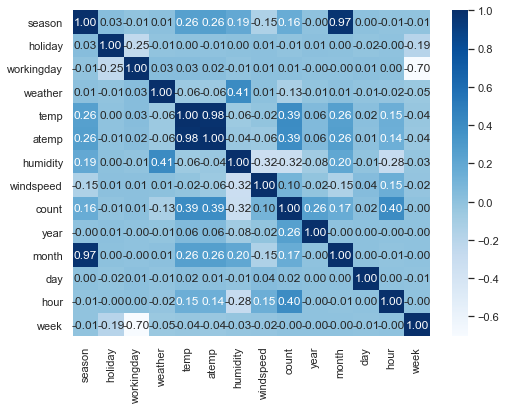

In [15]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(train.corr(), fmt='.2f', annot=True, cmap='Blues')

* count ==> temp, atemp, hour    
* season & month : 0.97 강하게 다중공선 
* atemp,  temp 강하게 다중공선    
* humidity(습도), weather : 0.41
* week , workingday : -0.70

### 1) season month

In [16]:
train['season'].unique()

array([1, 2, 3, 4], dtype=int64)

In [17]:
train['month'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

In [18]:
train[['season','month']].value_counts().sort_values()

season  month
1       1        884
        2        901
        3        901
2       4        909
3       9        909
4       10       911
        11       911
2       5        912
        6        912
3       7        912
        8        912
4       12       912
dtype: int64

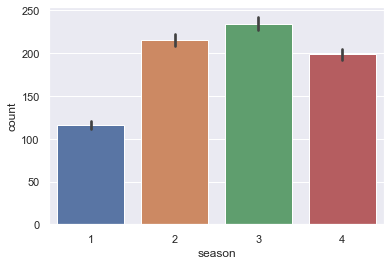

In [19]:
sns.barplot(x='season', y="count", data=train)
plt.show()

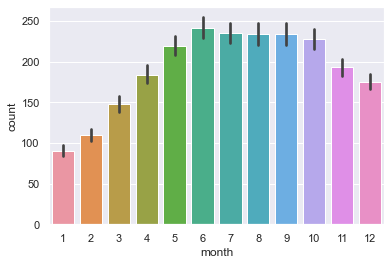

In [20]:
sns.barplot(x='month', y="count", data=train)
plt.show()

In [21]:
pd.crosstab(train['season'], train['month'])

month,1,2,3,4,5,6,7,8,9,10,11,12
season,,,,,,,,,,,,
1,884,901,901,0,0,0,0,0,0,0,0,0
2,0,0,0,909,912,912,0,0,0,0,0,0
3,0,0,0,0,0,0,912,912,909,0,0,0
4,0,0,0,0,0,0,0,0,0,911,911,912


In [22]:
pd.crosstab(test['season'], test['month'])

month,1,2,3,4,5,6,7,8,9,10,11,12
season,,,,,,,,,,,,
1,545,440,48,0,0,0,0,0,0,0,0,523
2,0,0,524,528,576,48,0,0,0,0,0,0
3,0,0,0,0,0,480,576,563,144,0,0,0
4,0,0,0,0,0,0,0,0,384,540,526,48


#### 2) week , workingday

In [23]:
train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour,week
0,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,1,0,5
1,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,1,1,5
2,1,0,0,1,9.02,13.635,80,0.0,32,2011,1,1,2,5
3,1,0,0,1,9.84,14.395,75,0.0,13,2011,1,1,3,5
4,1,0,0,1,9.84,14.395,75,0.0,1,2011,1,1,4,5


In [24]:
pd.crosstab(train['week'], train['workingday']).T

week,0,1,2,3,4,5,6
workingday,,,,,,,
0,239,0,24,0,48,1584,1579
1,1312,1539,1527,1553,1481,0,0


In [25]:
# dfdf = pd.DataFrame({"nn":[1,2,3]}, index=['a','b','c'])
# dfdf.index
# dfdf.loc['b']
# dfdf.iloc[1]

#### 방법1) 조건 필터 후 변경 - query

In [26]:
# train['working1_w04'] = 0
# train['working0_w56'] = 0

In [27]:
# idx = train.query( "workingday==1 and week in [0,1,2,3,4]")['working1_w04'].index
# # print(idx, len(idx))
# train['working1_w04'].loc[idx] = 1

# idx = train.query( "workingday==1 and week in [5,6]" )['working1_w04'].index
# # print(idx, len(idx))
# train['working1_w04'].loc[idx] = 0

# train['working1_w04'].value_counts()

#### 방법2) 조건 필터 후 변경 - lambda

In [28]:
x= train[['workingday','week']]
x.head(3)

,workingday,week
0,0,5
1,0,5
2,0,5


In [29]:
train['working1_peak_yn'] = train[['workingday','week']].apply(lambda x : (1,0) [x['workingday']==1   and  (x['week']!=5 or x['week']!=6) ], axis=1)
test['working1_peak_yn'] = test[['workingday','week']].apply(lambda x : (1,0) [x['workingday']==1   and  (x['week']!=5 or x['week']!=6) ], axis=1)

train['working1_peak_yn'].value_counts()

0    7412
1    3474
Name: working1_peak_yn, dtype: int64

In [30]:
train['working0_peak_yn'] = train[['workingday','week']].apply(lambda x : (1,0) [x['workingday']==0   and  (x['week']==5 or x['week']==6) ], axis=1)
test['working0_peak_yn'] = test[['workingday','week']].apply(lambda x : (1,0) [x['workingday']==0   and  (x['week']==5 or x['week']==6) ], axis=1)
train['working0_peak_yn'].value_counts()

1    7723
0    3163
Name: working0_peak_yn, dtype: int64

In [31]:
#train[train['week'].isin([1,2,3])]

#### 3) hour vs. count

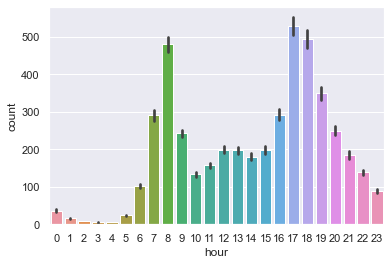

In [32]:
#---- 평일 ['workingday']==1  , 8시  17~18시
sns.barplot(x='hour', y="count", data=train[train['workingday']==1])
plt.show()

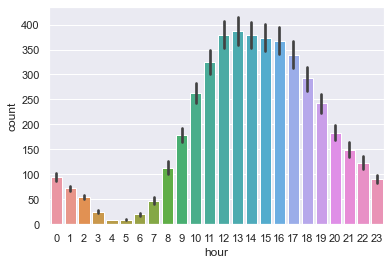

In [33]:
#---- 휴일 ['workingday']==0  ,12~16시
sns.barplot(x='hour', y="count", data=train[train['workingday']==0])
plt.show()

In [34]:

#---- 평일 ['workingday']==1  , 8시  17~18시
train['hour_peak_yn'] = train[['workingday','hour']].apply(lambda x : (1,0) [x['workingday']==1   and  (x['hour']==8 or 17<=x['hour']<=18) ], axis=1)
#---- 휴일 ['workingday']==0  , 12~16시  10~19시
train['hour_peak_yn'] = train[['workingday','hour']].apply(lambda x : (1,0) [x['workingday']==0   and  10<=x['hour']<=19 ], axis=1)


#---- 평일 ['workingday']==1  , 8시  17~18시
test['hour_peak_yn'] = test[['workingday','hour']].apply(lambda x : (1,0) [x['workingday']==1   and  (x['hour']==8 or 17<=x['hour']<=18) ], axis=1)
#---- 휴일 ['workingday']==0  , 12~16시  10~19시
test['hour_peak_yn'] = test[['workingday','hour']].apply(lambda x : (1,0) [x['workingday']==0   and  10<=x['hour']<=19 ], axis=1)


train['hour_peak_yn'].value_counts()




1    9436
0    1450
Name: hour_peak_yn, dtype: int64

### 4) 온도관련 피쳐 vs. count
* count ==> temp
* windspeed 
* humidity(습도), weather : 0.41

count    10886.00000
mean        20.23086
std          7.79159
min          0.82000
25%         13.94000
50%         20.50000
75%         26.24000
max         41.00000
Name: temp, dtype: float64


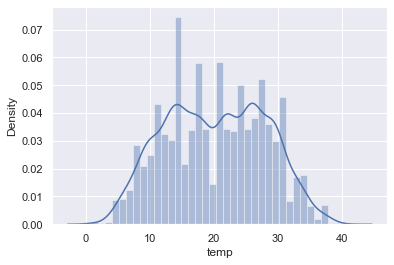

In [35]:
print(train['temp'].describe())
sns.distplot(train['temp'])   #10~30 
plt.show()

count    10886.000000
mean        61.886460
std         19.245033
min          0.000000
25%         47.000000
50%         62.000000
75%         77.000000
max        100.000000
Name: humidity, dtype: float64


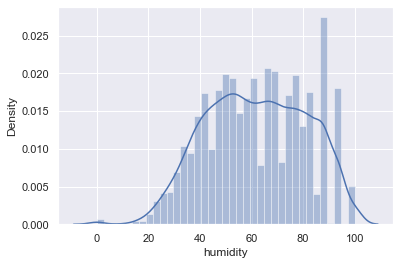

In [36]:
print(train['humidity'].describe())
sns.distplot(train['humidity'])   #30~90 
plt.show()

count    10886.000000
mean         1.418427
std          0.633839
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          4.000000
Name: weather, dtype: float64


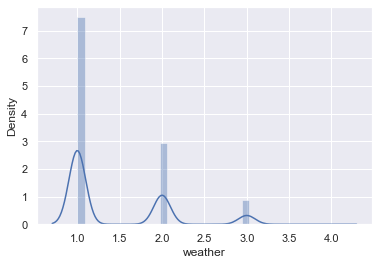

In [37]:
print(train['weather'].describe())
sns.distplot(train['weather'])   #1,2
plt.show()

count    10886.000000
mean        12.799395
std          8.164537
min          0.000000
25%          7.001500
50%         12.998000
75%         16.997900
max         56.996900
Name: windspeed, dtype: float64


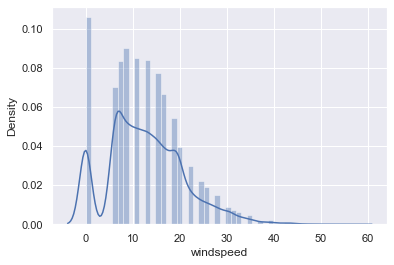

In [38]:
print(train['windspeed'].describe())
sns.distplot(train['windspeed'])   #0 ~24
plt.show()

In [39]:
# --------------------------------------
# train['temp']       #10~30 
# train['humidity']   #30~90 
# train['weather']    #1,2
# train['windspeed']  #0~24
# --------------------------------------
# weather - 날씨 
#   - 1: 맑음, 대체로 흐림, 일부 흐림 
#   - 2: 안개 + 흐림, 안개 + 깨진 구름, 안개 + 구름이 거의 없음, 안개 
#   - 3: 가벼운 눈, 가벼운 비 + 뇌우 + 흩어진 구름, 가벼운 비 + 흩어진 구름 
#   - 4: 폭우 + 얼음 팔레트 + 뇌우 + 안개, 눈 + 안개

train['weather_peak'] = train[['temp','humidity','weather','windspeed']].apply(lambda x : (1,0) [ 10<=x['temp']<=30 and  
                                                                                     30<=x['humidity']<=90 and 
                                                                                     x['weather'] in [1,2] and
                                                                                     0<=x['windspeed']<=24 ], axis=1)


test['weather_peak'] = test[['temp','humidity','weather','windspeed']].apply(lambda x : (1,0) [ 10<=x['temp']<=30 and  
                                                                                     30<=x['humidity']<=90 and 
                                                                                     x['weather'] in [1,2] and
                                                                                     0<=x['windspeed']<=24 ], axis=1)


train['weather_peak'].value_counts()

0    6506
1    4380
Name: weather_peak, dtype: int64

### 5) holiday
* 주어진 데이터 이외의 추가 휴일은 고려하지 않음

In [40]:
# train.loc[pd.datetime(2011, 6, 19)]['holiday']
train[train['holiday']==1][['workingday','year','month','day']].value_counts()

workingday  year  month  day
0           2011  1      17     24
                  4      15     24
                  7      4      24
                  9      5      24
                  10     10     24
                  11     11     24
            2012  1      16     24
                  4      16     24
                  7      4      24
                  9      3      24
                  10     8      24
                  11     12     24
                  1      2      23
dtype: int64

In [41]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   season            10886 non-null  int64  
 1   holiday           10886 non-null  int64  
 2   workingday        10886 non-null  int64  
 3   weather           10886 non-null  int64  
 4   temp              10886 non-null  float64
 5   atemp             10886 non-null  float64
 6   humidity          10886 non-null  int64  
 7   windspeed         10886 non-null  float64
 8   count             10886 non-null  int64  
 9   year              10886 non-null  int64  
 10  month             10886 non-null  int64  
 11  day               10886 non-null  int64  
 12  hour              10886 non-null  int64  
 13  week              10886 non-null  int64  
 14  working1_peak_yn  10886 non-null  int64  
 15  working0_peak_yn  10886 non-null  int64  
 16  hour_peak_yn      10886 non-null  int64 

### 원핫인코딩

In [42]:
ㄷㄳㄷㄴㄳㅈㄷㄱ ㅅㄱㄷ

SyntaxError: invalid syntax (Temp/ipykernel_24732/3299577829.py, line 1)

### 3) year
* 2011 0  , 2012  1  --> OnehotEncoding 
* 또는
* log1p()

In [ ]:
train['year'] = np.log1p(train['year'])
test['year'] = np.log1p(test['year'])

### 4) temp, atemp -- PCA

#### 스케일링

In [ ]:
train.describe()

#### X,y 타겟분리

In [ ]:
y = train['count'] 
X = train.drop(['count'], axis=1) 

In [ ]:
train.columns  #'datetime'- drop,  'count'-y분리
# scale_cols = ['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'year', 'month', 'day', 'hour', 'week']
scaler = StandardScaler()
scaler.fit(X)
train_scaler = scaler.transform(X)
test_scaler = scaler.transform(test)

In [ ]:
train = pd.DataFrame(train_scaler, columns = X.columns)
test = pd.DataFrame(test_scaler, columns = X.columns)
train.head()

#### PCA

In [ ]:
train[['temp','atemp']].head()

In [ ]:
pca = PCA(n_components=1)
pca.fit(train[['temp','atemp']])
train['PCA_temp_atemp'] = pca.transform(train[['temp','atemp']])
pca.fit(test[['temp','atemp']])
test['PCA_temp_atemp'] = pca.transform(test[['temp','atemp']])


print(pca.explained_variance_ratio_)


In [ ]:
train.drop(['temp','atemp'], axis=1, inplace=True)
test.drop(['temp','atemp'], axis=1, inplace=True)

In [ ]:
train.head()

In [ ]:
------------------------------ 오후 수업  여기서 부터 

In [ ]:
train_test = train.append(test)
train_test.shape

### 날짜데이터 처리

In [ ]:
from datetime import datetime as dt

train_test.head()

In [ ]:
dfdfd

## EDA

#### 기초통계

In [ ]:
train_test['temp'].describe()

In [ ]:
train_test['temp'].hist()

### 구간화(바이닝)
* dict - map()
* lambda & def - apply
* cut(), qcut()

In [ ]:
train_test.loc[train_test['temp']<=0, 'temp_band1'] = 1
train_test.loc[(train_test['temp']>0) & (train_test['temp']<=13), 'temp_band1'] = 2
train_test.loc[(train_test['temp']>13) & (train_test['temp']<=20), 'temp_band1'] = 3
train_test.loc[(train_test['temp']>20) & (train_test['temp']<=27), 'temp_band1'] = 4
train_test.loc[(train_test['temp']>27) & (train_test['temp']<=45), 'temp_band1'] = 5
train_test.loc[train_test['temp']>45, 'temp_band1'] = 6

In [ ]:
train_test['temp_band1'] = train_test['temp_band1'].astype('int')

In [ ]:
# 수치비교(부등호) 안되기때문에 현재 상황에서는 사용 불가 ==> 단일성 값의 경우에 사용
# dict = {"A":1, "B":2} 
# train_test['temp_band2'] =train_test['temp'].map(dict) 

In [ ]:
def temp_bind(x):
    temp_band1 = 0
    if x<=0:
        temp_band1 = 1
    elif (x>0) & (x<=13):
        temp_band1 = 2
    elif (x>13) & (x<=20):
        temp_band1 = 3
    elif (x>20) & (x<=27):
        temp_band1 = 4
    elif (x>27) & (x<=45):
        temp_band1 = 5
    else:
        temp_band1 = 6
    return temp_band1
train_test['temp_band2'] = train_test['temp'].apply(lambda x: temp_bind(x))

In [ ]:
train_test['temp_band3'] =pd.cut(train_test['temp'], bins=[-100,0,13,20,27,45,100], labels=[1,2,3,4,5,6])

In [ ]:
train_test[['temp','temp_band1','temp_band2','temp_band3']].head(20)